# L12 Spectral Partitioning of Bipartite Graphs

---

Typical example of bipartite graph is a graph obtained from a collection of documents presented as a _term $\times$ document_  matrix.

## Prerequisites

The reader should be familiar with k-means algorithm and spectral graph partitioning theory and algorithms.
 
## Competences 

The reader should be able to apply spectral partitioning of bipartite graphs to data clustering problems.

__Credits__: The notebook is based on [I. Mirošević, Spectral Graph Partitioning and Application to Knowledge Extraction][Mir05].

[Mir05]: #1 "I. Mirošević, 'Spectral Graph Partitioning and Application to Knowledge Extraction', M.Sc. Thesis, Iniversity of Zagreb, 2005 (in Croatian)." 

---

## Definitions

__Undirected bipartite graph__ $G$ is a triplet 
$G=(T,D,E)$, where $T=\{t_{1},\cdots ,t_{m}\}$ and 
$D=\{d_{1},...,d_{n}\}$ are two sets of vertices and
$E=\{(t_{i},d_{j}):t_{i}\in R,d_{j}\in D\}$, 
is a set of edges.

$G$ is __weighted__ if there is weight $\omega(e)$ associated with each edge $e\in E$.

For example, $D$ is a set of documents, 
$T$ is a set of terms (words) and  edge $e=(t_{i},d_{j})$ exists if
document $d_{j}$ contains term $t_{i}$. Weight $\omega(e)$ can be number of appearances 
of the term $t_i$ in the document $d_j$.

A __term-by-document-matrix__ is a matrix $A\in\mathbb{R}^{m\times n}$ with 
$A_{ij}=\omega((t_i,d_j))$.

## Facts

1. The weight matrix of $G$ is $W=\begin{bmatrix}0 & A \\ A^{T} & 0 \end{bmatrix}$.

2. The Laplacian matrix of $G$ is 
$L=\begin{bmatrix} \Delta_{1} & -A \\ -A^{T} & \Delta_{2}\end{bmatrix}$,
where $\Delta_1$ and $\Delta_2$ are diagonal matrices with elements 
$\Delta_{1,ii}=\sum_\limits{j=1}^n A_{ij}$ for $i=1,\ldots,m$, and 
$\Delta_{1,jj}=\sum_\limits{i=1}^m A_{ij}$ for $j=1,\ldots,n$.

3. The normalized Laplacian matrix of $G$ is 
$L_n=\begin{bmatrix}
I & -\Delta_{1}^{-\frac{1}{2}}A\Delta_{2}^{-\frac{1}{2}} \\
-\Delta_{2}^{-\frac{1}{2}}A^T\Delta_{1}^{-\frac{1}{2}} & I
\end{bmatrix} \equiv 
\begin{bmatrix} I & -A_n \\ -A_n^T & I \end{bmatrix}$.

4. Let $\lambda$ be an eigenvalue of $L_n$ with an eigenvector 
$w=\begin{bmatrix} u \\ v\end{bmatrix}$, where 
$u\in \mathbb{R}^{m}$ $v\in\mathbb{R}^{n}$.
Then $L_n w=\lambda w$ implies
$A_n v =(1-\lambda)u$ and $A_n^T u=(1-\lambda)v$. Vice versa, if $(u,\sigma,v)$ is a singular triplet of $A_n$, then $1-\sigma$ is an eigenvalue of $L_n$ with (non-unit) eigenvector $w=\begin{bmatrix} u \\ v\end{bmatrix}$. 

5. The second largest singular value of $A_n$ corresponds to the second smallest eigenvalue of $L_n$, and computing the former is numerically more stable. 

5. _Bipartitioning algorithm_ is the following:
    1. For given $A$ compute $A_{n}$.
    2. Compute singular vectors of $A_{n}$, $u^{[2]}$ and $v^{[2]}$, which correspond to 
    the second largest singular value, $\sigma_2(A_n)$.
    3. Assign the partitions $T=\{T_1,T_2\}$ and $D=\{D_1,D_2\}$ according to the signs of 
    $u^{[2]}$ and $v^{[2]}$. The pair $(T,D)$ is now partitioned as 
    $\{(T_1,D_1),(T_2,D_2)\}$.


6. _Recursive bipartitioning algorithm_ is the following:
    1. Compute the bipartition $\pi=\{(T_1,D_1),(T_2,D_2)\}$ of 
    $(T,D)$. Set the counter $c=2$.
    2. While $c<k$ repeat
         1. compute bipartitions of each of the subpartitions of $(T,D)$,
         2. among all $(c+1)$-subpartitions, choose the one with the smallest 
         $pcut(\pi_{c+1})$ or $ncut(\pi_{c+1})$, respectively.
    3. Set $c=c+1$
    3. Stop

7. _Multipartitioning algorithm_ is the following:
    1. For given $A$ compute $A_{n}$.
    2. Compute $k$ left and right singular vectors, $u^{[1]},\ldots,u^{[k]}$ and 
    $v^{[1]},\ldots,v^{[k]}$, which correspond to $k$ largest singular values 
    $\sigma_1\geq \cdots \geq \sigma_k$ of $A_n$.
    3. Partition the rows of matrices 
    $\Delta_{1}^{-\frac{1}{2}}\begin{bmatrix} u^{[1]} & \ldots & u^{[k]}\end{bmatrix}$
    and 
    $\Delta_{2}^{-\frac{1}{2}}\begin{bmatrix} v^{[1]} & \ldots & v^{[k]}\end{bmatrix}$
    with the k-means algorithm.

### Example - Small term-by- document matrix

In [1]:
using Graphs
using IJuliaPortrayals
using Clustering

In [2]:
# Sources, targets, and weight
dn=[6,6,6,7,7,7]
tn=[1,2,3,2,4,5]
wn=[3,1,2,3,2,3]
[dn tn wn]

6x3 Array{Int64,2}:
 6  1  3
 6  2  1
 6  3  2
 7  2  3
 7  4  2
 7  5  3

In [3]:
G = inclist(ExVertex, ExEdge{ExVertex}; is_directed=false)
for i=1:5
    add_vertex!(G, ExVertex(i,"$i"))
    attrs=attributes(G.vertices[i],G)
    attrs["label"]="Term $i"
end

for i=1:2
    add_vertex!(G, ExVertex(i+5,"$(i+5)"))
    attrs=attributes(G.vertices[i+5],G)
    attrs["label"]="Document $i"
end

for i=1:6
    add_edge!(G, vertices(G)[dn[i]], vertices(G)[tn[i]])
end
for i=1:length(G.inclist)
    for j=1:length(G.inclist[i])
        ei=G.inclist[i][j]
        attrs = attributes(ei, G)
        attrs["label"] = wn[edge_index(ei,G)]
    end
end

In [4]:
# Plot
GraphViz(to_dot(G),"fdp","svg")

IJuliaPortrayals.GraphViz("graph graphname {\n1 [\"label\"=\"Term 1\"]\n1 -- 6 [\"label\"=\"3\"]\n2 [\"label\"=\"Term 2\"]\n2 -- 6 [\"label\"=\"1\"]\n2 -- 7 [\"label\"=\"3\"]\n3 [\"label\"=\"Term 3\"]\n3 -- 6 [\"label\"=\"2\"]\n4 [\"label\"=\"Term 4\"]\n4 -- 7 [\"label\"=\"2\"]\n5 [\"label\"=\"Term 5\"]\n5 -- 7 [\"label\"=\"3\"]\n6 [\"label\"=\"Document 1\"]\n7 [\"label\"=\"Document 2\"]\n}\n","fdp","svg")

In [5]:
W=weight_matrix(G,wn)

7x7 Array{Int64,2}:
 0  0  0  0  0  3  0
 0  0  0  0  0  1  3
 0  0  0  0  0  2  0
 0  0  0  0  0  0  2
 0  0  0  0  0  0  3
 3  1  2  0  0  0  0
 0  3  0  2  3  0  0

In [6]:
A=W[1:5,6:7]
Δ1=sqrt(sum(A,2))
Δ2=sqrt(sum(A,1))
An=map(Float64,[A[i,j]/(Δ1[i]*Δ2[j]) for i=1:size(A,1), j=1:size(A,2)])

5x2 Array{Float64,2}:
 0.707107  0.0     
 0.204124  0.53033 
 0.57735   0.0     
 0.0       0.5     
 0.0       0.612372

In [7]:
# The partitioning - explain the results!
U,σ,V=svd(An)

(
5x2 Array{Float64,2}:
 -0.46291    0.604743
 -0.534522  -0.218218
 -0.377964   0.493771
 -0.377964  -0.370328
 -0.46291   -0.453557,

[0.9999999999999999,0.8838834764831844],
2x2 Array{Float64,2}:
 -0.654654   0.755929
 -0.755929  -0.654654)

### Example - Sets of points

In [10]:
using Gadfly
using Images

In [11]:
?sprand

search: sprand sprandn sprandbool StepRange sparse2adjacencylist



```rst
..  sprand([rng,] m,n,p [,rfn])

Create a random ``m`` by ``n`` sparse matrix, in which the probability of any
element being nonzero is independently given by ``p`` (and hence the mean
density of nonzeros is also exactly ``p``). Nonzero values are sampled from
the distribution specified by ``rfn``. The uniform distribution is used in
case ``rfn`` is not specified. The optional ``rng`` argument specifies a
random number generator, see :ref:`Random Numbers <random-numbers>`.
```


In [12]:
# Define sizes
m=[200,100,100]
n=[100,200,100]
density=[0.5,0.7,0.4]
A=Array(Any,3)
for i=1:3
    A[i]=sprand(m[i],n[i],density[i])
end
B=blkdiag(A[1],A[2],A[3])

400x400 sparse matrix with 27985 Float64 entries:
	[1  ,   1]  =  0.63275
	[4  ,   1]  =  0.959481
	[8  ,   1]  =  0.184358
	[12 ,   1]  =  0.330302
	[14 ,   1]  =  0.73624
	[15 ,   1]  =  0.722103
	[16 ,   1]  =  0.221057
	[17 ,   1]  =  0.476368
	[18 ,   1]  =  0.340688
	[20 ,   1]  =  0.964822
	⋮
	[365, 400]  =  0.187379
	[367, 400]  =  0.109261
	[372, 400]  =  0.800895
	[373, 400]  =  0.937715
	[375, 400]  =  0.148107
	[378, 400]  =  0.31176
	[382, 400]  =  0.0360761
	[384, 400]  =  0.951725
	[385, 400]  =  0.019434
	[395, 400]  =  0.0616016
	[396, 400]  =  0.367914

In [13]:
pB=spy(B)
draw(Gadfly.PNG("pB.png", 4inch, 4inch), pB)

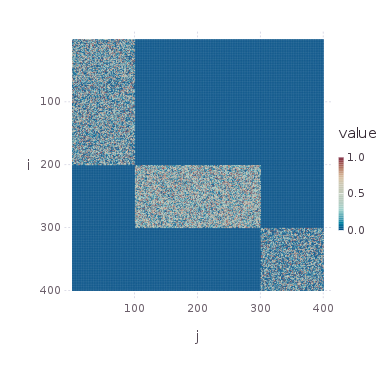

In [14]:
using Images
load("pB.png")

In [15]:
# The structure of singular vectors reflects the blocks
U,σ,V=svds(B,nsv=3)

(
400x3 Array{Float64,2}:
 -1.2228e-17   -0.0756504    -9.81308e-18
  1.3953e-17   -0.0645528     1.96262e-17
  1.82654e-17  -0.066132      1.96262e-17
  9.85141e-18  -0.0561065     2.45327e-17
  2.19644e-17  -0.0783662     9.81308e-18
 -1.81887e-17  -0.0751636     0.0        
  3.54957e-17  -0.0702335    -1.47196e-17
  8.37562e-18  -0.0655986    -4.90654e-18
  7.12981e-18  -0.0786918    -2.94392e-17
 -1.07331e-17  -0.0685266    -4.41589e-17
  5.37611e-17  -0.0852744    -4.90654e-17
  1.86103e-17  -0.0589439    -1.47196e-17
  9.92807e-18  -0.074484     -9.81308e-18
  ⋮                                      
  1.31844e-17  -1.67759e-17   0.117946   
 -1.30764e-18  -1.46599e-17   0.107477   
  2.78052e-17   9.47969e-18   0.12547    
 -9.37106e-18  -2.29492e-17   0.0882664  
 -1.89314e-17  -2.13083e-17   0.0980954  
  8.59213e-18   7.67822e-18   0.101157   
  3.12049e-18   8.94491e-18   0.0980892  
  1.53159e-17   1.15867e-17   0.105902   
  1.57875e-17  -5.87698e-18   0.0957914  
 -8.8740

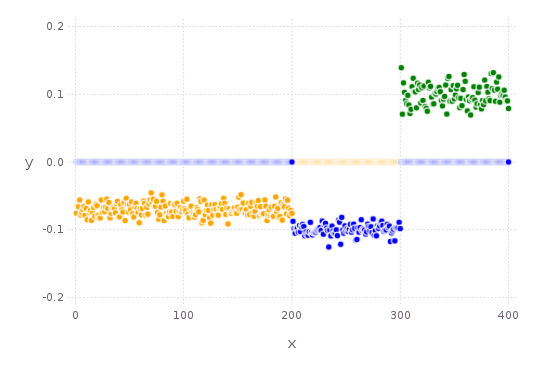

In [16]:
k=size(B,1)
x=collect(1:k)
Gadfly.plot(layer(x=x,y=U[:,1],Geom.point,Theme(default_color=colorant"blue")),
layer(x=x,y=U[:,2], Geom.point,Theme(default_color=colorant"orange")),
layer(x=x,y=U[:,3], Geom.point,Theme(default_color=colorant"green")))

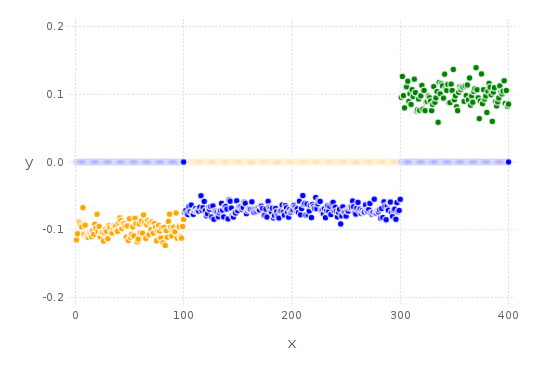

In [17]:
Gadfly.plot(layer(x=x,y=V[:,1],Geom.point,Theme(default_color=colorant"blue")),
layer(x=x,y=V[:,2], Geom.point,Theme(default_color=colorant"orange")),
layer(x=x,y=V[:,3], Geom.point,Theme(default_color=colorant"green")))

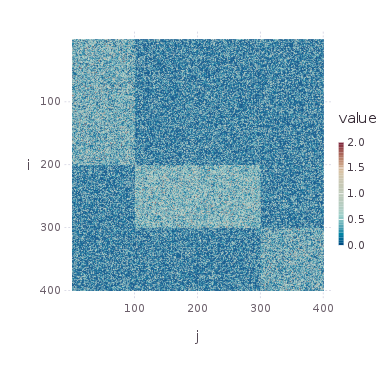

In [18]:
# Add random noise
noise=sprand(k,k,0.3)
C=B+noise
pC=spy(C)
draw(Gadfly.PNG("pC.png", 4inch, 4inch), pC)
load("pC.png")

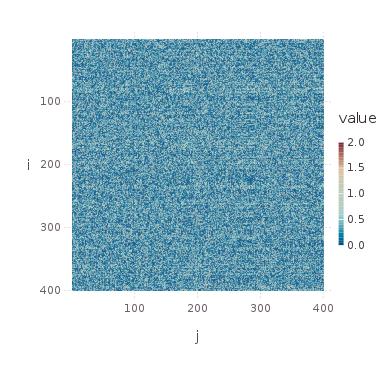

In [19]:
# Apply random permutation to rows and columns of C
D=C[randperm(k),randperm(k)]
pD=spy(D)
draw(Gadfly.PNG("pD.png", 4inch, 4inch), pD)
load("pD.png")

In [20]:
# Given D, can we recover C with spectral partitioning?
U,σ,V=svds(D,nsv=3)

(
400x3 Array{Float64,2}:
 0.0455024  -0.041783   -0.0117251 
 0.0614191   0.0643511  -0.00242959
 0.0645826   0.0748169  -0.0244326 
 0.0381559  -0.0578774  -0.0279462 
 0.0787397   0.087013   -0.0383457 
 0.0421128  -0.0529026  -0.0237152 
 0.0378041  -0.0165563   0.0729723 
 0.037513   -0.026672    0.0916729 
 0.0385036  -0.0579666  -0.007756  
 0.0462035  -0.0509887  -0.0216047 
 0.0348635  -0.0182817   0.0589996 
 0.0460073  -0.0405911  -0.0175847 
 0.0432442  -0.0460798  -0.0342067 
 ⋮                                 
 0.049218   -0.0436618  -0.0292491 
 0.0448648  -0.0577681  -0.0255373 
 0.0425096  -0.0130693   0.087046  
 0.0483553  -0.0518682  -0.0518036 
 0.0710632   0.0701775  -0.0278791 
 0.0490255  -0.04982    -0.0269322 
 0.0654914   0.0680815  -0.00672278
 0.0407475  -0.0531266  -0.0287095 
 0.0392537  -0.0459604  -0.0310052 
 0.0626324   0.0545035  -0.0184223 
 0.0392561  -0.037426   -0.0365534 
 0.0688428   0.0784923  -0.00378933,

[98.42325473564878,42.13604023193137

In [21]:
# Kmeans on rows and U and V
using Clustering

In [22]:
outU=kmeans(U',3)

Clustering.KmeansResult{Float64}(3x3 Array{Float64,2}:
  0.068764    0.0381787   0.0433762
  0.0694793  -0.0154755  -0.0482633
 -0.0161974   0.0874769  -0.0253855,[3,1,1,3,1,3,2,2,3,3  …  2,3,1,3,1,3,3,1,3,1],[0.000233123,0.000269799,0.000113792,0.000126238,0.000897491,2.59095e-5,0.000211691,0.000143412,0.000428697,2.97167e-5  …  2.47319e-5,0.0007357,0.000142234,3.673e-5,0.000102433,4.16107e-5,5.38796e-5,0.00026682,0.000259143,0.000235201],[100,100,200],[100.0,100.0,200.0],0.11219325329717528,4,true)

In [23]:
outV=kmeans(V',3)

Clustering.KmeansResult{Float64}(3x3 Array{Float64,2}:
  0.037917    0.0540794   0.0515671
 -0.0229422   0.0431882  -0.0738111
  0.0859702  -0.0109169  -0.0401641,[1,2,3,3,2,2,1,2,3,1  …  2,1,1,2,1,2,2,2,2,2],[0.000131639,0.000300493,5.47083e-5,0.000165632,4.17232e-5,5.12097e-5,7.55412e-5,1.52926e-5,0.000359733,0.000130328  …  0.000433532,0.00133717,0.000385065,9.47234e-5,0.000348588,0.000494417,0.000401753,0.000272834,0.00061124,0.00054151],[100,200,100],[100.0,200.0,100.0],0.11067401965563649,2,true)

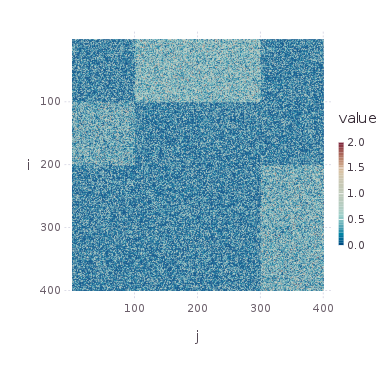

In [24]:
E=D[sortperm(outU.assignments),sortperm(outV.assignments)]
pE=spy(E)
draw(Gadfly.PNG("pE.png", 4inch, 4inch), pE)
load("pE.png")